# Fast Ascent Algorithm
Daniel Alejandro Alonso Bastos

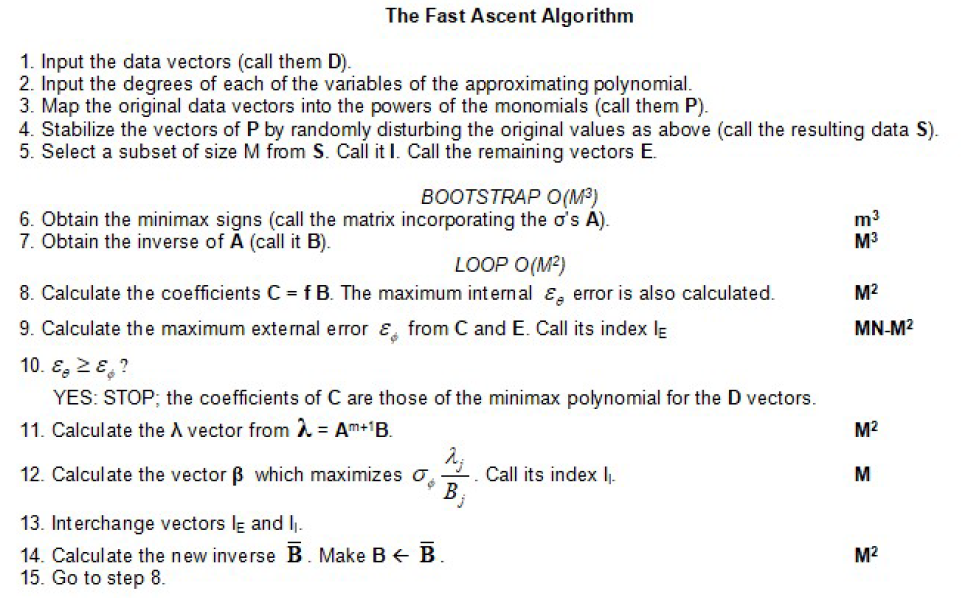

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
from numba import jit
from IPython.display import display, Latex

import warnings

#suppress warnings
warnings.filterwarnings('ignore')

## Descripción de funciones

A continuación se colocan algunas funciones optimizadas para realizar el producto punto entre vectores. Es importante tener instalada la paquetería de numba

In [2]:
@jit
def dot_numba(a,b):
    length = len(a)
    c = np.zeros(length)
    for i in range(length):
        res = 0
        for j in range(len(b)):
            res += a[i,j]*b[j]
        c[i] = res
    return c

@jit
def dot_lambda(a,b):
    length = len(a)
    c = np.zeros(length)
    for i in range(length):
        res = 0
        for j in range(len(b)):
            res += b[j,i]*a[j]
        c[i] = res
    return c

@jit
def argmax(array):
    max_val = -1e9
    idx = 0
    for i in range(len(array)):
        if array[i] > max_val:
            max_val = array[i]
            idx = i
    return idx

El primer paso es que el usuario ingrese la ruta del archivo txt o csv con los datos a procesar, junto con el separador. La función que lee los datos y los transforma a un array es la función _readData._ Nótese que para que el programa funcione es necesario que la estrcutura sea $x_1,x_2,...,x_n,f(x_1,x_2,...,x_n)$. Es decir, las primeras columnas son las variables independientes y la última columna es la variable dependiente.

In [3]:
def readData(path,delimiter='tab'):
    '''
    Funcion leer un archivo y hacer la separacion por tabulador si el usuario ingresa 'tab' o coma ','
    Nota: No soporta UTF-8
    
    Inputs:
    paht: str - Ruta del archivo a leer
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    
    Return
    data: array - Estructura de tipo array para manipular los datos 
    '''
    try:
        if delimiter == 'tab':
            data = np.genfromtxt(path,delimiter='\t')
        elif delimiter == ',':
            data = np.genfromtxt(path,delimiter=',')     
        return data
    except:
        print('El separador seleccionado no es compatible')

La función _introducePerturbation_ le introduce una ligera perturbación del orden $\delta_H$ a los datos, tal que:

\begin{equation}
    X_i^* =
    \left\{\begin{matrix}
        X_i \times (1+\rho_u\cdot\delta_H) & if & X_i\neq 0\\ 
        \rho_u\cdot\delta_H & if & X_i=0 
    \end{matrix}\right.
\end{equation}

donde $X_i^*$ es el nuevo valor con una ligera perturbación, $X_i$ es el valor actual, $\rho_u \in [0,1]$ es un número aleatorio y $\delta_H$ es el factor de perturbación.

In [4]:
@jit # decorador para optimizar el codigo
def introducePerturbation(data,factor=1/1e6):
    '''
    Funcion que agrega una perturbacion del orden de factor a un conjunto de datos
    
    Input:
    data: array - Conjunto de datos al que se le quiere agregar una perturbacion
    factor: float - Factor de perturbacion
    
    Return:
    data_noise: array - Conjunto de datos con perturbacion
    
    '''
    rows,cols = data.shape
    data_noise = np.zeros((rows,cols)) # inicializar arreglo data_noise
    
    # iterar para cada elemento del arreglo
    for row in range(rows):
        for col in range(cols):
            if data[row,col] == 0: # si X = 0
                data_noise[row,col] = random.random()*factor
            else: # si X != 0
                data_noise[row,col] = data[row,col]*(1+random.random()*factor)
        
    return data_noise

La función _validateDimensions_ valida que el dataset tenga al menos $M$ tuplas, en caso de pasar la validación se retorna el conjunto de datos original, en caso de no cumplir con la validación se duplica la información del conjunto de datos hasta cumplir con la condición $rows\geq M$

In [5]:
def validateDimensions(data,coef_combinations):
    '''
    Funcion para validar que el dataset contenga al menos M tuplas, en caso de pasar la validacion
    se retorna el dataset original, en caso de no cumplir con la validacion se duplica la informacion 
    del dataset hasta cumplir con la condicion rows>=M
    
    Inputs:
    data: array - matriz con los datos originales
    coef_combinations: list - Lista con las combinaciones de las potencias de los monomios
    
    Return:
    data_validated: array - matriz que cumple con la condicion rows>=M
    '''
    m = len(coef_combinations) # numero de variables independientes para calcular
    M = m + 1 # variables independientes mas el error
    # el dataset debe de tener al menos M tuplas  
    data_validated = data.copy() # generar una copia del dataset original
    # en caso de no cumplir, duplicar informacion hasta cumplir condicion
    while data_validated.shape[0] < M:
        # concatenar informacion
        data_validated = np.concatenate((data_validated,data))
    return data_validated

La función _coefficientCombination_ genera la combinación de los exponentes que tendrán las variables para hasta 4 variables en el rango $n$ que defina el usuario. P.ej., si el usuario ingresa la lista $[1,1,1]$ la función regresa la combinación de los exponenetes tal que $[000,001,010,011,100,101,110,111]$.

In [6]:
def coefficientCombination(degree_variables):
    '''
    Funcion para generar una lista con la combinacion de exponentes que tendran los coeficientes
    Nota: La funcion solo soporta hasta 4 variables
    
    Inputs:
    degree_variables: list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
    
    Return
    coef_comb: list - Lista con las combinaciones
    '''
    n = len(degree_variables) # numero de variables
    degree_arr = np.array(degree_variables) + 1
    coef_comb = [] # inicializar lista para guardar combinaciones
    if n == 1: # para 1 variable
        for i in range(degree_arr[0]):
            coef_comb.append(str(i))
    if n == 2: # para 2 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                coef_comb.append(str(i)+str(j))
    if n == 3: # para 3 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                for k in range(degree_arr[2]):
                    coef_comb.append(str(i)+str(j)+str(k))
    if n == 4: # para 4 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                for k in range(degree_arr[2]):
                    for l in range(degree_arr[3]):
                        coef_comb.append(str(i)+str(j)+str(k)+str(l))
    return coef_comb

La función _map2powers_ mapea los vectores de datos originales en las potencias de los monomios y los almacena en la matriz $P$:

Por ejemplo, sea la función $f(x,y)$ y se quiere aproximar con un dos variables de grado 1 como máximo, tal que las combinaciones de las potencias son $[00,01,10,11]$:

\begin{align}
Para~c_{00}: x^0y^0\\
Para~c_{01}: x^0y^1\\
Para~c_{10}: x^1y^0\\
Para~c_{11}: x^1y^1
\end{align}

Donde cada coeficiente $c$ representa una columna de la matriz $P$, siendo $m$ el conjunto de las combinacioes de las potencias, y esto se realiza para las $N$ tuplas de los datos originales, por lo que la matriz $P$ es:

\begin{equation}
P=\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1m}\\ 
X_{21} & X_{22} & \cdots & X_{2m} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
X_{N1} & X_{N2} & \cdots & X_{Nm} 
\end{bmatrix}
\end{equation}

En la función _map2powers_ se agrega al final la columna de la variable dependiente $f(X)$, esto con el objetivo de mantenerla en el intercambio de vectores entre conjuntos, tal que:

\begin{equation}
P'=\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1m} & f_1\\ 
X_{21} & X_{22} & \cdots & X_{2m} & f_2\\ 
\vdots & \vdots & \vdots & \vdots & \vdots\\ 
X_{N1} & X_{N2} & \cdots & X_{Nm} & f_N
\end{bmatrix}
\end{equation}

In [7]:
@jit
def map2powers(data_set,coef_comb):
    '''
    Funcion para mapear los vectores de un conjunto de datos originales (variables x1,x2,...,xn) a las potencias
    de los monomios, dicho mapeo es la matriz P. P.ej., si se tiene el grado de los polinomios '000' entonces el 
    valor P11 de la matriz P se calcula como P11=x1^0*x2^0*x3^0.
    
    La matriz P tendra las dimensiones de Nxn_degree+1, donde N es el numero de filas del conjunto original y 
    n_degree es el numero de combinacinoes de las potencias de los monomios. El +1 es para agregar la columna
    de los valores de la variable dependiente f(X), que por convencion se deja como la ultima columna de data_set
    
    Inputs:
    data_set: array - Conjunto de datos originales
    coef_comb: list - Lista con las combinaciones de las potencias de los monomios
    
    Returns:
    P: array - Matriz de dimension Nxn_degree+1 con el mapeo de los datos originales a las potencias de los monomios
        + columna con la variable dependiente f
    
    '''
    # obtener dimensiones del conjunto original
    N, columns = data_set.shape
    # numero de combinaciones de las potencias de los monomios
    n_degree = len(coef_comb)
    # el numero de variables independientes del conjunto original menos 1, ya que la ultima columna es f(X)
    n_variables = columns-1
    # inicializar matriz P
    P = np.zeros((N,n_degree+1))
    # convertir a array
    #coef_comb_array = np.array(coef_comb)
    for row in range(N): # iterar para cada tupla
        for column in range(n_degree): # iterar para cada combinacion de potencias
            coef = 1 #inicializar
            for i in range(n_variables): # iterar para cada potencia en la combinacion[i]
                grade = coef_comb[column][i] #recuperar str con el exponente de la variable segun la combinacion
                #grade = coef_comb_array[column][i] #recuperar str con el exponente de la variable segun la combinacion
                coef *= data_set[row,i]**int(grade) #multiplicar las variables elevadas con su respectivo exponente
            P[row,column] = coef # actualizar valores
            
    # actualizar ultima columna con el valor de la variable dependiente f (por convencion es la ultima columna de data_set)
    P[:,-1] = data_set[:,-1]
    return P

La función _generatePerturbationS_ realiza una perturbación a la matriz $P'$ pero sin modificar los valores de la variable dependiente $f(X)$.

In [8]:
@jit
def generatePerturbationS(matrix,factor=1/1e6):
    '''
    Funcion para generar la matriz S, que toma a la matriz con los datos originales mapeados a las 
    potencias de los monomios + columna con la variable dependiente f. Para asegurar que la matriz no 
    sea singular se le introduce una perturbacino a los datos mapeados, pero NO se le introdice una perturbacion
    a la variable dependiente F
    
    Inputs:
    matrix: array - Matriz de dimension Nxn_degree+1 con el mapeo de los datos originales a las potencias de los monomios
        + columna con la variable dependiente f
    factor: float - Factor de perturbacion
    
    Returns:
    S: array - Matriz con los valores mapeados con una cierta perturbacion, y la variable dependiente sin perturbacion
    '''
    rows,cols = matrix.shape
    S = np.zeros((rows,cols))
    # introducir perturbacion a todos los datos a excepcion de la ultima columna
    # por convencion la ultima columna es la variable dependiente
    S[:,:-1] = introducePerturbation(matrix[:,:-1],factor)
    # agregar los valores originales de la variable dependiente
    S[:,-1] = matrix[:,-1]
    return S

La función _solveMinimaxSigns_ resuelve los signos minimax de la matriz $A$:

\begin{equation}
A=\begin{bmatrix}
\sigma_1 & X_{11} & X_{12} & \cdots & X_{1m}\\ 
\sigma_2 & X_{21} & X_{22} & \cdots & X_{2m} \\ 
\vdots  & \vdots & \vdots & \vdots & \vdots \\ 
\sigma_M & X_{M1} & X_{M2} & \cdots & X_{Mm} 
\end{bmatrix}
\end{equation}

donde:
- $\sigma_i = (-1)^{i+1}sgn(\Delta_{i'})$, $\sigma_i$ es el signo de los determinantes, y $\Delta_{i'}$ representa el determinante al eliminar la primera columna y la $i$-ésima fila de la matriz.
- $m$ es el número de variables independientes.
- $M$ es el número de variables independientes más el error, tal que $M=m+1$
- Nótese que es la matriz $P$ agregando una columna inicial de los signos $\sigma_i$ que se quieren resolver.

Para resolver los signos $\sigma_i$ se utiliza el teorema de cofactores (COT), dondese fija el signo del $m$-ésimo cofactor como -1, y se calculan los demás signos al resolver el sistema de ecuaciones.

In [9]:
def solveMinimaxSigns(matrix):
    '''
    Funcion para calcular los signos minimax de una matriz M.
    La matriz matrix cuenta con el valor de la variable dependiente en la ultima columna, por lo que se
    tiene que eliminar para obtener los signos minimax.
    El primer paso es agregar una columna de ceros a la matriz para calcular los signos.
    Después se calculan los signos por el teorema de COT, al suponer que el signo del m-esimo factor es -1
    y despues se resuelve el SE
    
    Inputs:
    matrix: array - Matriz a la cual se quiere resolver los signos
                  
    Returns:
    A_matrix: array - Matriz A del SE, con la columna de signos calculada
    '''
    # eliminar columna de la variable dependiente
    matrix =  matrix[:,:-1]
    # agregar una columna a la izquierda con ceros a la matriz ingresada para poder resolver el SE
    M,columns = matrix.shape # obtener dimensiones de la matriz M
    A_matrix = np.zeros((M,M)) # inicializar matriz A de tamanio (MxM) -> se agrega una columna a la matriz M
    A_matrix[:,1:] = matrix # colocar los valores de la matriz M despues de la primer columna (signos)
    
    # obtener los signos con el metodo de COT    
    ## metodo indirecto (tipo 2), el valor del M-esimo cofactor es igual a -1 y se resuelve el SE
    # transponer matriz sin la columna de los signos
    aux_matrix = A_matrix[:,1:].T
    # dejar el valor del m-esimo cofactor =-1
    mth_cofactor = -1
    # separar la matriz A (M-1 columnas) y el vector b (ultima columna) para resolver el SE 
    A_solve = aux_matrix[:,:-1]
    b_solve = mth_cofactor*-aux_matrix[:,-1]
    # resolver SE y obtener los signos
    sign_list = np.sign(np.linalg.solve(A_solve,b_solve))
    # agregar m-esimo cofactor
    sign_list = np.append(sign_list,mth_cofactor)
    # actualizar columna de signos de la matriz A_matrix
    A_matrix[:,0] = sign_list
    
    return A_matrix

El sistema de ecuaciones que se quiere resolver es el siguiente:

\begin{equation}
\begin{bmatrix}
\sigma_1 & X_{11} & X_{12} & \cdots & X_{1m}\\ 
\sigma_2 & X_{21} & X_{22} & \cdots & X_{2m} \\ 
\vdots  & \vdots & \vdots & \vdots & \vdots \\ 
\sigma_M & X_{M1} & X_{M2} & \cdots & X_{Mm} 
\end{bmatrix}
\begin{bmatrix}
\epsilon_\theta\\ 
c_1\\ 
c_2\\ 
\vdots\\ 
c_M
\end{bmatrix} = 
\begin{bmatrix}
f_1\\ 
f_2\\ 
\vdots\\ 
f_M
\end{bmatrix}
\end{equation}

Que de forma compacta es $AC=f$, donde:
- $A$ es la matriz del modelo incluyendo los signos minimax
- $C$ es el vector de los coeficientes del polinomio minimax
- $f$ es el vector de la variable dependiente

Para hacer más eficiente la obtención de los coeficientes $c_i$ y el error interno $\epsilon_\theta$, se calcula la matriz inversa de $A$, tal que $B=A^{-1}$, por lo que el vector $C$ puede ser calculado como:

\begin{equation}
C=fB
\end{equation}

La función _get_e_phi_ calcula el error de un conjunto de datos, siendo $\epsilon_\phi$ el error del conjunto de datos externo. Siendo:

\begin{equation}
    \epsilon_i = |f_i-y_i|,~~\epsilon_\phi=max(\epsilon_1,\cdots,\epsilon_N)
\end{equation}

Donde $f_i$ es el valor original, y $y_i$ es el valor aproximado. La función _get_e_phi_ retorna el valor máximo del error en el conjunto externo $\epsilon_\phi$, el signo del error $\sigma_{I_E}$, el índice donde se ecuentra $I_E$, el vector $y_i$ evaluado para todos los vectores del conjunto y el vector $A^{I_E}$ que está conformado por $\sigma_{I_E}$ y las $m$ variables, tal que:

\begin{equation}
    A^{I_E} = [\sigma_{I_E},X_{I_E,1},X_{I_E,2},...,X_{I_E,m}]
\end{equation}

In [10]:
def get_e_phi(data_set,solution_coef):
    '''
    Funcion para calcular el error e_phi un conjunto de datos, ademas de identificar el indice donde se encuentra
    el valor maximo, y los resultados y_i al utilizar los coeficientes de una lista
    
    Inputs:
    data_set: array - Conjunto externo de datos (tambien se puede emplear cualquier conjunto para calcular y_i)
    solution_coef: array - Arreglo con el valor de los coeficientes
    
    Return:
    e_phi: float - Valor del error maximo en el conjunto al realizar |f_i-y_i|
    e_phi_idx: int - Indice donde se encuentra el error maximo e_phi
    e_phi_sign: float - Signo del error e_phi
    y_i: array - Arreglo con los valores de y_i al utilizar los coeficientes en solution_coef
    A_IE: array - Vector que esta conformado por el signo de e_phi (e_phi_sign) y los valores de las combinaciones
        de potencias del vector en la posicion I_E (e_phi_idx)
    '''
    rows,cols = data_set.shape
    comb_matrix = data_set[:,:-1] # obtener la matriz de combinaciones (solo quitar la ultima fila -> f(X))
    
    # realizar producto punto entre la matriz de combinaciones y el arreglo con el valor de los coeficientes para calcular y_i
    #y_i = np.dot(comb_matrix,solution_coef)
    y_i = dot_numba(comb_matrix,solution_coef)
    # calcular vector de errores sin valor absoluto (para obtener el signo del error)
    e_i_real = data_set[:,-1] - y_i
    # calcular vector de errores absolutos e_i
    e_i = np.abs(e_i_real)
    # calcular el error maximo e_phi, su signo y el indice donde se encuentra
    e_phi = np.max(e_i)
    #e_phi_idx = np.argmax(e_i)
    e_phi_idx = argmax(e_i)
    e_phi_sign = np.sign(e_i_real[e_phi_idx])
    
    # generar vector A_IE (signo del error e_phi mas los m variables del polinomio aproximador)
    # mismo numero de columnas que el data_set
    A_IE = np.zeros(cols)
    # actualizar primer elemento con el signo del error
    A_IE[0] = e_phi_sign
    # actualizar el resto de valores con la matriz de combinaciones
    A_IE[1:] = comb_matrix[e_phi_idx,:]
    
    return e_phi, e_phi_idx, e_phi_sign, y_i, A_IE

Colocar el vector externo $A^{I_E}$ en función de los valores conocidos de la matriz $A$:

\begin{equation}
    A^{I_E} = \lambda A
\end{equation}

Cuya solución es:

\begin{equation}
    \lambda = A^{I_E}B
\end{equation}

Una vez que se obtiene $\lambda$, se busca el índice $I_I$ del error interno $\epsilon_\theta$ que maximice:

\begin{equation}
   \sigma_{I_E} \dfrac{\lambda_j}{B_j^1}
\end{equation}

Donde $\sigma_{I_E}$ es el signo del error del vector $A^{I_E}$, $B_j^1$ es iterar los $j$ elementos de la primera columna de la matriz $B$.

La función _getInternalIndex_ realiza la operación para calcular el índice donde se encuentra el valor máximo de realizar la ecuación anterior, dicho índice $I_I$ es el que se usará para intercambiar con el conjunto externo.

In [11]:
def getInternalIndex(sigma_IE,lambda_vector,matrixB):
    '''
    Funcion para calcular el indice del error maximo interno e_theta al realizar sigma_IE*(lambda/B),
    de tal manera que el signo del error externo se mantenga
    
    Inputs:
    sigma_IE: float - Signo del error maximo del vector A_IE (conjunto externo)
    lambda_vector: array - vector lambda (relacion del error externo con la inversa del conjunto interno B)
    matrixB: array - matriz inversa del conjunto interno
    
    Returns:
    e_theta_idx: int - indice donde se encuentra el error maximo e_theta en el conjunto interno
    '''
    epsilon_vector = sigma_IE*lambda_vector/matrixB[0]
    #e_theta_idx = np.argmax(epsilon_vector) # encontrar el indice donde se encuentra el max
    e_theta_idx = argmax(epsilon_vector) # encontrar el indice donde se encuentra el max (optimizado)
    return e_theta_idx

La función _swapVectors_ realiza el intercambio de 1 vector en los conjuntos internos y externos respectivamente.

In [12]:
@jit
def swapVectors(inner_setF,inner_idx,outer_setF,outer_idx):
    '''
    Funcion para realizar el intercambio de 1 vector en 2 conjuntos de datos
    
    Inputs:
    inner_setF: Conjunto interno (puede ser cualquier otro conjunto)
    inner_idx: Indice del conjunto interno a intercambiar
    outer_setF: Conjunto externo (puede ser cualquier otro conjunto)
    outer_idx: Indice del conjunto externo a intercambiar
    
    Return:
    inner_setF, outer_setF: array - Conjunto interno y externo con los vectores intercambiados
    '''
    # cambiar valores
    aux_copy = inner_setF[inner_idx,:].copy()
    inner_setF[inner_idx,:] = outer_setF[outer_idx,:]
    outer_setF[outer_idx,:] = aux_copy
    return inner_setF, outer_setF

Una vez que se tiene el intercambio de vectores $A^\theta$ y $A^\phi$, se tiene que encontrar los coefiecientes $C$ nuevos, para ello una opción es volver a calcular los signos minimax y realizar la inversa de la matriz, lo que tiene un costo de $O(n^3)$. Otra opción es utilizar el teorema de la inversa de una matriz que dice:

Sea:
- $A$ una matriz no singular, i.e., que se pueda resolver
- $B$ su matriz inversa con $B_1,B_2,...,B_m$ columnas
- Sea $\overline{A}$ la matriz resultante al remplazar la $\beta$-ésima fila de $A$ por un vector $v$

Si $\lambda_\beta\equiv <v,B_\beta>\neq0$ entonces $\overline{A}$ es no singular y las columnas de su inversa se calculan de la siguiente manera:

\begin{align}
    \overline{B}_\beta&=B_\beta/\lambda_\beta \\
    \overline{B}      &=B_j-<v,B_j>\overline{B}_\beta ~ para ~ j\neq\beta
\end{align}

El valor de $\beta$ corresponde al índice del erro máximo interno $I_I$. Al realizar esta operación se tiene la nueva inversa $B$ sin tener que resolver los signos minimax y después obtener su inversa, esta operación toma $O(n^2)$. Por lo que se emplea esta metodología para calcular la nueva matriz inversa $B$.

La función _updateInverse_ realiza dicha operación y devuelve la nueva matriz inversa $B$.

In [13]:
@jit
def updateInverse(B_matrix,lambda_vector,e_theta_idx):
    '''
    Función para calcular la nueva matriz inversa B en función de una mtriz inversa B,
    un vector lambda y un indice beta, que en este caso es el indice del error maximo
    interno e_theta_idx
    
    Inputs:
    B_matrix: array - Matriz inversa B que se va a actualizar
    lambda_vector: - array - Vector de lambdas
    e_theta_idx: int - Indice del error maximo del conjunto interno
    
    Returns:
    B_matrix: array - Matriz inversa B actualizada
    '''
    rows,cols = B_matrix.shape
    # realizar B_beta=B_beta/lambda_b
    for i in range(rows):
        B_matrix[i,e_theta_idx] = B_matrix[i,e_theta_idx]/lambda_vector[e_theta_idx]
        
    # realizar B = B-lambda*B_beta para todo i!=beta (i!=e_theta_idx)
    for i in range(cols):
        for j in range(rows):
            if i==e_theta_idx:
                break
            B_matrix[j,i] = B_matrix[j,i]-lambda_vector[i]*B_matrix[j,e_theta_idx]
    return B_matrix

La función _calculateRMS_ calcula el $\varepsilon_{RMS}$ dado un vector de los originales $f_i$ y los aproximados $y_i$

In [14]:
def calculateRMS(y,y_hat):
    '''
    Funcion para calcular el error RMS (e_rms)
    
    Inputs:
    y: array - Vector con los valores reales de f(X)
    y_hat: array - Vector con los valores aproximados
    
    Returns:
    e_rms: float - Error RMS
    '''
    diff_square = (y_hat - y)**2
    e_rms = np.sqrt(diff_square.mean())
    return e_rms

La función _getEquation_ genera la ecuación resultante en formato LaTex

In [15]:
def getEquation(C_values,degree_coef,round_precision=3):
    '''
    Funcion para generar la ecuacion en formato latex
    
    Inputs:
    C_values: list - lista con el valor de e_theta y los coeficientes (output de FAA)
    degree_coef: list - lista con la combinacion de las potencias de las variables
    round_precision: int - numero de decimales en el redondeo
    
    Returns:
    equation: str - ecuacion resultante en formato latex
    '''
    C = C_values.copy()
    # inicializar cadena equation donde se guardara la ecuacion
    equation = r'f(X)='
    # obtener el valor de los coeficientes manteniendo el signo
    for i in range(1,len(C)):
        exp = '' # inicializar string para guardar las variables con sus exponentes
        if C[i] >= 0: # si el valor del coeficiente es positivo
            coeficient = '+' + str(round(C[i],round_precision))
        else: # si es negativo
            coeficient = str(round(C[i],round_precision))
        
        # obtener la expresion de las variables con sus exponentes
        for j in range(1, len(degree_coef[i-1])+1):
            if degree_coef[i-1][j-1] == '0':
                continue
            if degree_coef[i-1][j-1] == '1':
                exp += r'x_{' + str(j) +'}'
            else:
                exp += r'x_{' + str(j) +'}^{' + str(degree_coef[i-1][j-1]) + '}'
        equation += coeficient + exp

    return equation

La función _sortY_ ordena los valores de la variable dependiente $f_i$ y los aproximados $y_i$ en función de los originales $f_i$, con el objetivo de mostrar las gráficas de mejor manera en caso de que la información no sea muy visible.

In [23]:
def sortY(y_real,y_approx):
    '''
    Funcion para ordenar y_real y y_hat en funcion de y_real, con el objetivo de mostrar las graficas
    de mejor manera, en caso de que aplique
    
    Inputs:
    y_real: array - vector con los valores de y real
    y_approx: array - vector con los valores de y aproximada 'y_hat'
    
    Return:
    y_real_sorted: array - vector con los valores de y real ordenados
    y_approx_sorted: array - vector con los valores de y aproximada 'y_hat' ordenados en funcion de y_real
    '''
    # juntar arreglos en lista: [y_real,y_approx]
    y_join = [[y_real[i],y_approx[i]] for i in range(len(y_real))]
    # ordenar lista en funcion de y_real
    sorted_y_join = sorted(y_join, key=lambda x: x[0])
    # separar listas
    y_real_sorted = np.array(sorted_y_join)[:,0]
    y_approx_sorted = np.array(sorted_y_join)[:,1]
    return y_real_sorted, y_approx_sorted

La función _FAA_ es la función principal, es la encargada de ejecutar todo el algoritmo de __Fast Ascent Algorithm__, al realizar los pasos mostrados al inicio del documento, además de visualizar los resultados.

Nótese que para ejecutar el algoritmo solo es necesario la ruta del archivo donde se encuentran los datos y la lista con el grado máximo de cada variable.

In [33]:
def FAA(data_path,degree_variables=[],coefficient_list=[],delimiter='tab',
        stabilize_data=True,stabilize_factor=1/1e6,quasi_factor=0.0,max_iterations = 10000,
        plot_results=True,plot_sort=False,save_results=True,save_name='results.txt'):
    '''
    Funcion principal para ejecutar Fast Ascent Algorithm, donde se realizan los siguientes pasos:
    1. Lectura y procesamiento
        a. Leer archivo
        b. Generar combinacion de exponentes de los polinomios
        c. Validar que cumple con la restriccion N>=M, en caso de que no, duplicar data hasta cumplir restriccion
        d. Mapear los vectores originales a las potencias de polinomios (P)
        e. Estabilizar a P al introducirlo una pequenia perturbacion (opcional)
        f. Seleccionar el conjunto interno de tamanio M, y el restante es el conjunto externo
    2. BOOTSTRAP (fase de arranque) -> O(m^3)
        a. Calcular los signos minimax por medio del teorema de coeficientes COT -> A
        b. Obtener la inversa de A -> B
    3. LOOP (ejecutar hasta cumplir con la condicion de convergencia e_theta>=e_phi) -> O(m^2)
        a. Calcular los coeficientes y el error e_theta al resolver C=fB -> C
        b. Calcular el error maximo interno e_phi, el indice I_E y el vector agregando el signo de e_phi (sigma_IE) -> A_IE
        c. Revisar criterio de convergencia e_theta>=e_phi
        d. Calcular el vector lambda: lambda=A_IE*B
        e. Calcular el indice I_I (beta) que maximiza el error interno e_theta de la expresión: sigma_IE*(lambda/B)
        f. Intercambiar los vectores I_I e I_E de los conjuntos internos y externos
        g. Calcular la nueva inversa B con el teorema de la inversa de una matriz
    4. PLOT (mostrar resultados)
        a. Grafica de los errores e_theta y e_phi en funcion de las iteraciones
        b. Grafica de la funcion original con la funcion polinomial aproximada
        c. Impresion de los resultados: e_theta, e_rms y el valores de los m coeficientes, tiempo de ejecucion y ecuacion
    
    Inputs:
    data_path: str - Ruta del archivo a leer
    degree_variables: list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
        Por default, esta vacia, el usuario puede ingresar tambien la lista de coeficientes
    coefficient_list: list - Lista con los coeficientes a utilizar. P.ej., ['00','01','10','11']
        Por default, esta vacia, el usuario puede ingresar el grado maximo de las variables y el algoritmo
        obtiene las combinaciones
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    stabilize_data: boolean - bandera que indica si se desea estabilizar los datos (True por default)
    stabilize_factor: float - factor de estabilizacion
    quasi_factor: float - factor para una convergencia de FAA, p.ej., si es 0.05, el algoritmo converge cuando e_phi
        tiene una diferencia menor del 5% de e_theta. Ayuda a terminar el algoritmo mas rapido
    max_iterations: int - numero maximo de iteraciones permitido, para que el programa se detenga en caso de no converger
    plot_results: boolean - bandera para indicar si se grafican e imprimen los resultados
    plot_sort: boolean - bandera para determinar si la grafica y_i vs yhat_i se ordena (para que se vea mejor)
    save_results: boolean - bandera para guardar resultados en la carpeta local donde se ejecuta el programa de la solucion,
        que es el error minimax mas los coeficientes de la funcion aproximante
    save_name: str - nombre del archivo donde se guardaran los resultados
    
    Returns:
    C: array - Arreglo con los valores de e_theta y los m coeficientes
    residuals: list - lista con el registro de los residuales [t,e_theta,e_phi]
    e_rms: float - Error RMS
    '''
    # start time
    start_time = time.time()
    # ************ READ AND PROCESSING ************
    # 1. Input the data vectors (D)
    D = readData(data_path,delimiter=delimiter)
    # 2. Input the degrees of each variables of the approximating polynomial
    ## en caso de que el usuario ingrese el grado de cada potencia
    ## generar combinacion de las potencias del polinomio aproximante
    if degree_variables != []:
        coef_comb = coefficientCombination(degree_variables)
    ## en caso de que el usuario ingrese las combinaciones que se quiere probar
    if coefficient_list !=[]:
        coef_comb = coefficient_list
    ## validar condicion N>=M
    D = validateDimensions(D,coef_comb)
    ## validar 
    # 3 Map the original data vectors into the powers of the monomials (P)
    P = map2powers(D,coef_comb)
    # 4 (optional) Stabilize the vectors of P by random disturbing the original values (S)
    if stabilize_data:
        S = generatePerturbationS(P,factor=stabilize_factor)
    else:
        S = P.copy()
    # 5 Select a subset of size M from S. I (inner_set), and the remaining E (outer_set)
    ## calculo de parametros importantes para la ejecucion
    rows, columns = S.shape
    m = len(coef_comb) # numero de variables independientes para calcular
    M = m + 1 # variables independientes mas el error
    ## generacion de los conjuntos interno y externo
    inner_set = S[:M,:]
    outer_set = S[M:,:]

    # ************ BOOTSTRAP ************
    # 6 Obtain the minimax signs (call the matrix incorporating sigmas A)
    A = solveMinimaxSigns(inner_set)
    # 7 Obtain the inverse of A (call it B)
    B = np.linalg.inv(A)
    
    # ************ LOOP ************
    run = True
    t = 0 # inicializar tiempo
    residuals = [] # inicializar lista para guardar las variables de residuales [t,e_theta,e_phi]
    # ejecutar hasta encontrar la solucion
    while run:
        # 8 Calculate the coefficients C=fB. The max internal error e_theta is also calculated
        f_vector = inner_set[:,-1] # obtener variable dependiente f(X)
        #C = np.dot(B,f_vector) # C=fB
        C = dot_numba(B,f_vector) # C=fB (optimizado)
        e_theta = C[0] # obtener error theta
        # 9 Calculate the maximum external error e_phi from C and E
        e_phi, e_phi_idx, e_phi_sign, y_i, A_IE = get_e_phi(outer_set,C[1:])        
        # 10 Check convergence
        if e_theta*(1+quasi_factor)>=e_phi or t>max_iterations:
                # terminar ejecucion
                run = False
        ## en caso de tener el criterio de convergencia continuar
        # 11 calculate the lambda vector from lambda = A_IE*B
        #lambda_vector = np.dot(A_IE,B)
        lambda_vector = dot_lambda(A_IE,B) # (optimizado)
        # 12 calculate the vector beta which maximizes sigma*(lambda/B). Call its index I_I
        e_theta_idx = getInternalIndex(e_phi_sign,lambda_vector,B)
        # 13 Interchange vector Ie (e_phi_idx) and Ii (e_theta_idx)
        inner_set, outer_set = swapVectors(inner_set,e_theta_idx,outer_set,e_phi_idx)
        # 14 Calculate the new inverse B
        B = updateInverse(B,lambda_vector,e_theta_idx)
        
        # actualizar tiempo y residuales
        t+=1 #incrementar paso de tiempo
        if plot_results: residuals.append([t,e_theta,e_phi]) #agregar resultados del paso actual
    
    # end time
    end_time = time.time() - start_time
    
    # ************ PLOT RESULTS ************
    _, _, _, y_i, _ = get_e_phi(P,C[1:]) # calculo de y_i con los coeficientes solucion
    # calculate e_rms error
    e_rms = calculateRMS(D[:,-1],y_i)
    
    # get equation
    equation = getEquation(C,coef_comb)
    
    if plot_results:
        # plot residuals
        arr_plot = np.array(residuals)
        plt.figure(figsize=(12, 8))
        plt.plot(arr_plot[:,0],arr_plot[:,1],label=r'$\varepsilon_\theta$')
        plt.plot(arr_plot[:,0],arr_plot[:,2],label=r'$\varepsilon_\phi$')
        plt.legend(loc='upper right', ncol=2, prop={"size":15})
        plt.xlabel(r'$t$',fontsize=14)
        plt.ylabel(r'$Error$',fontsize=14)
        plt.title(r'Inner Error $\varepsilon_\theta$ vs Outer Error $\varepsilon_\phi$',fontsize=16)
        plt.show()

        # plot results
        plt.figure(figsize=(12, 8))
        if plot_sort: # en caso de graficar de manera ordenada en funcion de los valores originales
            y_sorted, y_hat_sorted = sortY(D[:,-1],y_i) # ordenar
            plt.plot(y_sorted,label=r'$y$')
            plt.plot(y_hat_sorted,marker='.', markersize=10,label=r'$\widehat{y}$')
        else: # en caso de no querer graficar de manera ordenada
            plt.plot(D[:,-1],label=r'$y$')
            plt.plot(y_i,marker='.', markersize=10,label=r'$\widehat{y}$')
        plt.legend(loc='upper right', ncol=2, prop={"size":15})
        plt.xlabel(r'$step$',fontsize=14)
        plt.ylabel(r'$f_i$',fontsize=14)
        plt.title(r'Original function $y_i$ vs Approximated Function $\widehat{y}_i$  $\varepsilon_\theta \approx $ '+str(C[0]),
                  fontsize=16)
        plt.show()
        
        # print results
        print('\n*** RESULTS ***')
        print("E_RMS: \t%12.10f " % e_rms)
        for i in range(M):
            if i==0: # e_theta
                print("E_minimax: \t%12.10f " % (C[i]))
            else: # coeficientes
                print(f'C{coef_comb[i-1]} = %12.10f' % C[i])
        # tiempo
        print("\nExecution time \t%12.10f s " % (end_time))
        
        # display equation
        display(Latex(f'${equation}$'))
    
    # save results in a txt file
    if save_results:
        
        print("\nIn the Results File the following will be written:" )
        print("a) The coefficients, the minimax error and rms error" )
        print("b) Approximation and Original data\n" )
        
        try:
            FDO1 = open(save_name,"w+")
        except:
            print("Unable to create file "+save_name+"\"")
            sys.exit("**** End of program ****\n\n\n")
        #endTrydat
        FDO1.write("E_RMS: \t%12.10f \n" % e_rms)
        for i in range(M):
            if (i==0):
                FDO1.write("E_minimax: \t%12.10f \n" % (C[i]))
            else:
                FDO1.write(f'C{coef_comb[i-1]}\t %12.10f \n' % C[i])
            #endIf
        #endFor
        # ecuacion
        FDO1.write(f'\nEquation:\n{equation}\n')
        # tiempo
        FDO1.write("\nExecution time \t%12.10f s \n\n" % (end_time))
        N=rows
        FDO1.write("index\tApproximation Values\tData Values\n\n")
        for i in range(N):
            FDO1.write("(%2.0f)\t %12.10f \t%12.10f \n" % (i,y_i[i],D[i,-1]))
        #endFor
        FDO1.close()

    return C, residuals, e_rms

## Ejercicio

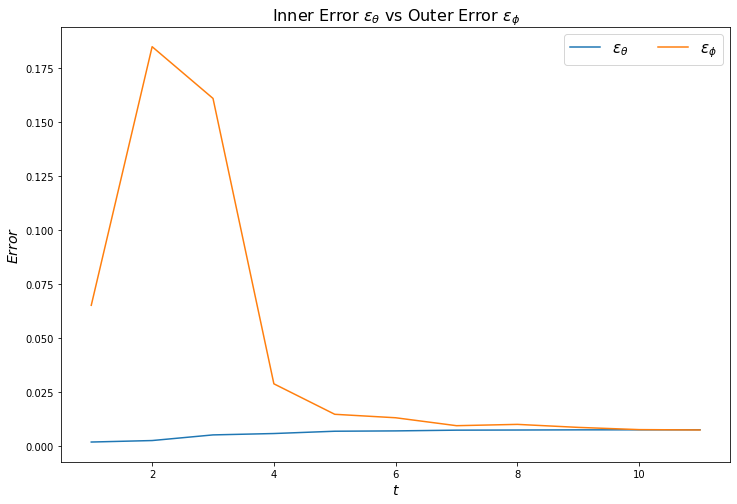

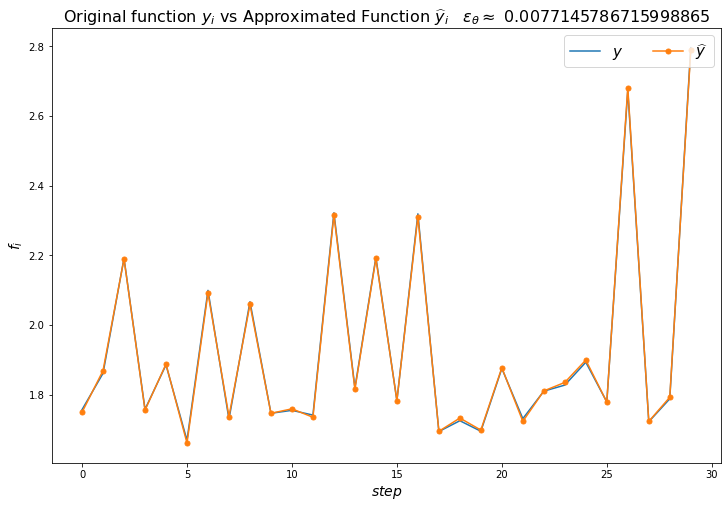


*** RESULTS ***
E_RMS: 	0.0055303676 
E_minimax: 	0.0077145787 
C000 = 0.3584597738
C001 = 0.7886396769
C010 = -1.0235564456
C011 = 0.2256587319
C100 = -0.3413129112
C101 = 1.2752683760
C110 = -0.0646329383
C111 = 0.0223544093

Execution time 	0.0020310879 s 


<IPython.core.display.Latex object>


In the Results File the following will be written:
a) The coefficients, the minimax error and rms error
b) Approximation and Original data



In [35]:
solution,residuals,e_rms = FAA('1_Examen Alonso.txt',degree_variables=[1,1,1],coefficient_list=[],delimiter='tab',
        stabilize_data=True,stabilize_factor=1/1e6,quasi_factor=0.0,max_iterations = 10000,
        plot_results=True,plot_sort=False,save_results=True,save_name='results.txt')

## Ejercicio 2

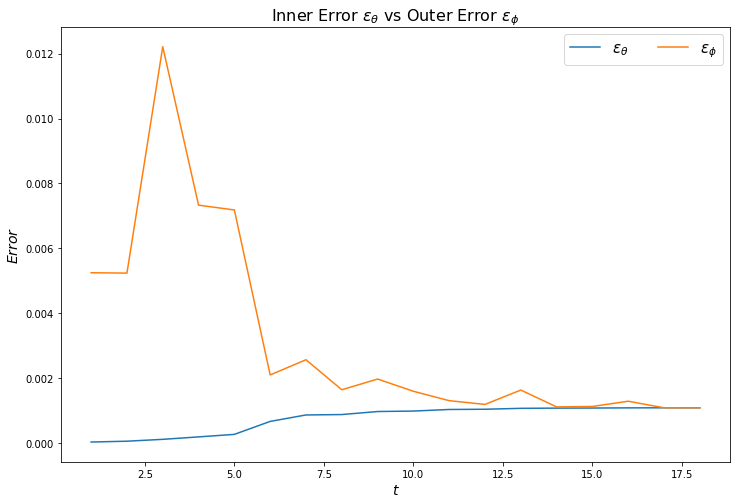

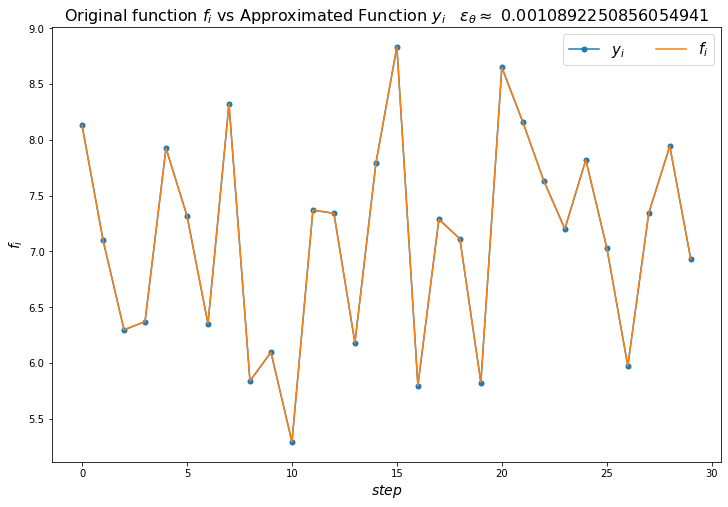


*** RESULTS ***
E_RMS: 	0.0008718572 
E_minimax: 	0.0010892251 
C000 = 1.2946756367
C001 = -10.9266748412
C010 = -10.1670614657
C011 = 0.0208602036
C100 = 9.8961250656
C101 = 20.7633574874
C110 = 0.0209605832
C111 = 0.0030331628

Execution time 	0.0019938946 s 


<IPython.core.display.Latex object>


In the Results File the following will be written:
a) The coefficients, the minimax error and rms error
b) Approximation and Original data



In [22]:
solution,residuals,e_rms = FAA('1_Examen Bandala.txt',degree_variables=[1,1,1],coefficient_list=[],delimiter='tab',
        stabilize_data=True,stabilize_factor=1/1e6,quasi_factor=0.0,max_iterations = 10000,
        plot_results=True,save_results=True,save_name='results.txt')

## Resumen de resultados

En la siguiente tabla se muestran la comparación en iteraciones y tiempo entre los algoritmos Naive (NAA) y Fast (FAA) de ascenso para dos ejercicios distintos.

|Examen|Algoritmo|Pasos|Tiempo [s]|
|:--------:|:--------:|:--------:|:--------:|
Alonso | NAA | 38 | 0.013 |
Alonso | FAA | 11  | 0.0029 |
Bandala | NAA | 52 | 0.016 |
Bandala | FAA | 13 | 0.0039 |

Se observa que utilizar el algoritmo __FAA__ se disminuye el tiempo en un orden de magnitud.

## Ejecución del archivo .py

Para ejecutar el programa es necesario ejecutar el programa __FastAscentAlgorithm.py__, el cual le pedirá al usuario los parámetros _data_path_ y _degree_variables_:

- _Ingresa la ruta del archivo:_ El usuario debe ingresar la dirección del archivo ya sea en formato _csv_ o _txt_.
- _Ingresa el tipo de separador (, o tab):_ El usuario debe ingresar ',' en caso de que la separación de los datos sea con coma o 'tab' si es por tabulador. Una vez ingresado se guarda en la variable
- _Ingresa la lista con el grado maximo de variables. Ejemplo:[1,1,1]:_ El usuario debe de ingresar una lista con el formato especificado con el grado máximo de las variables con las que se quiere aproximar.

Después de que el usuario ingresa los parámetros de manera correcta se ejecuta el programa principal (función __FAA__), una vez finalizado se muestran las gráficas de los errores y la comparación de los resultados obtenidos, se imprime en consola el valor del $\epsilon_\theta$, los coeficientes $c_i$ y el tiempo de ejecución. Además se guardan en el directorio local dos archivos _txt_, el primero de nombre _solution.txt_ que guarda el vector con el $\epsilon_{RMS}$ y los coeficientes $c_i$, y el otro archivo se llama _yi.txt_ que contiene los valores obtenidos del poinomio minimax.

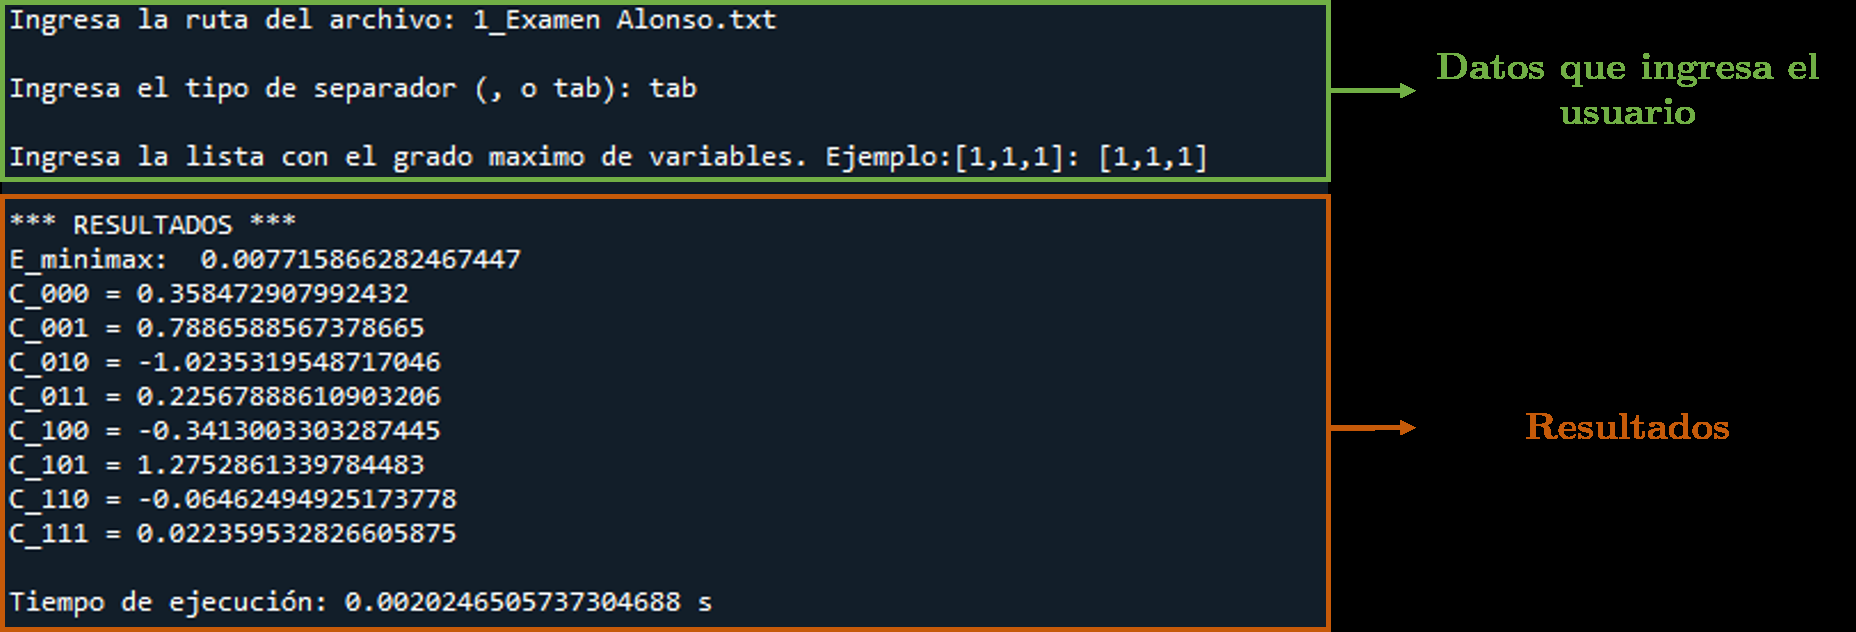